# The Category of Elements
A very useful construction in applied category theory is the Category of Elements, which is also called the Grothendieck construction. This is a very general technique in category theory, but we will look at how you can use it to explain why graphs are so useful in computer science. We have already seen that C-Sets are a model of relational databases that can be used to store data as a collection of interlocking tables. Relational databases are the bread and butter of the computing industry. Every company on earth uses software that is backed by a relational database. Most data that is not stored in a relational DB is often stored in some kind of graph data structure. This sketch will show how these approaches are interchangeable via the category of elements, which associates to every database instance a graph and a graph homomorphism into the schema of the graph.

In [1]:
using GATlab, Catlab.CategoricalAlgebra, Catlab.Graphs, Catlab.Graphics
using Colors

Let's tell Catlab how to draw categories of elements.

In [2]:
function graph(el::Elements)
  F = FinFunctor(Dict(:V => :El, :E => :Arr), Dict(:src => :src, :tgt => :tgt),
                 SchGraph, SchElements)
  ΔF = DataMigrationFunctor(F, Elements{Symbol}, Graph)
  return ΔF(el)
end

safecolors(start, stop, len) = if len > 1
  return hex.(range(start, stop=stop, length=len))
else
  return [hex.(start)]
end

function draw(f::Elements; kw...)
  pg = to_graphviz_property_graph(graph(f);
    node_labels=true, edge_labels=true, prog="neato", kw...)
  vcolors = safecolors(colorant"#0021A5", colorant"#FA4616", nparts(f, :Ob))
  ecolors = safecolors(colorant"#6C9AC3", colorant"#E28F41", nparts(f, :Hom))
  for v in parts(f, :El)
    fv = f[v, :πₑ]
    set_vprops!(pg, v, Dict(:color => "#$(vcolors[fv])", :label=>"$v:$(f[v,[:πₑ, :nameo]])"))
  end
  for e in parts(f, :Arr)
    fe = f[e, :πₐ]
    set_eprops!(pg, e, Dict(:color => "#$(ecolors[fe])"))
  end
  to_graphviz(pg)
end

draw(g) = to_graphviz(g, node_labels=true, edge_labels=true, prog="neato")

draw (generic function with 2 methods)

## The simplest schema
First we will look at discrete dynamical systems. The set S is our state space and the funct nxt associates to every state, the next state in the system. This is a deterministic dynamical system with finitely many states and discrete time.

In [3]:
@present SchDDS(FreeSchema) begin
  S::Ob
  nxt::Hom(S, S)
end

@acset_type DDS(SchDDS, index=[:nxt])

fₓ = @acset DDS begin
  S = 3
  nxt = [2,3,1]
end

S,nxt
1,2
2,3
3,1


Now if you want to draw a DDS, you might think to draw each state as a vertex and the next relationship as an arrow from one state to the next state. If your intuition selected that representation, you have already discovered a special case of the category of elements

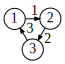

In [4]:
elᶠ = elements(fₓ)
draw(graph(elᶠ))

As you are quite far in your category theoretic training, you are surely suspicious of the idea that you would construct the category of elements of a DDS and get a graph. We have a categorical construction, so your intuition should be saying "there should be some kind of morphism that goes with this object". And there is, the Elements of a C-Set X is a graph whose vertices are rows in the tables of X and whose edges are the foreign key relationships in X, along with a graph homomorphism into the schema C. We can draw this using the same color coding convention we used to draw graph homomorphisms.

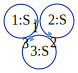

In [5]:
draw(elᶠ)

We can scale up our DDS drawing too.

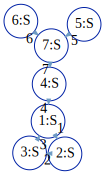

In [6]:
Fₓ = @acset DDS begin
  S = 7
  nxt = [2,3,1, 1,7,7,4]
end
draw(elements(Fₓ))

A category of elements derived from a C-Set is stored as a C-Set of on a different schema. You can see that it is the data of a graph homomorphism where the codomain graph has vertex and edge labels. The two projections πₑ and πₐ are the components of a natural transformation between graphs viewed as functors into Set. The names are attributes usually of type Symbol.

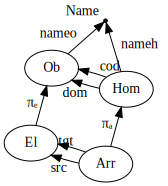

In [7]:
to_graphviz(SchElements)

In the case of a DDS, we have only one object and one morphism in the schema. Since the graph with one edge and one vertices is terminal in *Graph*, there is only one vertex and edge color being used.

## The Elements of a Graph are its Vertices and Edges
In what might appear as primordial ooze, we can examine the category of elements of a graph. We will look at the commuting triangle graph. Notice how there are 3 vertices and three edges with each edge incident to 2 vertices.

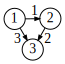

In [8]:
g = @acset Graph begin
  V = 3
  E = 3
  src = [1,2,1]
  tgt = [2,3,3]
end
draw(g)

The category of elements has 6 vertices and 6 edges. The 6 vertices come from 3 vertices of type V and 3 vertices of type E. The 6 edges in this graph are 3 src relationships and 3 target relationships.

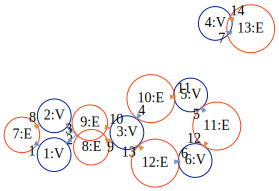

In [9]:
elᵍ = elements(g)
draw(elᵍ)

g = @acset Graph begin
  V = 6
  E = 7
  src = [1,2,1,3,5,6,4]
  tgt = [2,3,3,5,6,3,4]
end
draw(g)
draw(elements(g))

Notice that the 3 vertices of type E are interspersed between the 3 vertices of type V and vice versa. You can see that the normal visual syntax for a graph is more compact for the special case of graphs. However the category of elements works for any schema C.

## Generality of the construction
Discrete Dynamical Systems and Graphs are clearly data structures from mathematics and so it would make sense that they have a clean representation in the categorical language. But how about a database schema that comes not from mathematics, but from software engineering. We turn to everyone's favorite database example, the HR database at a fictitious company.

In [10]:
@present SchCompany(FreeSchema) begin
  (P, D, S)::Ob # Person, Department, Salary
  worksin::Hom(P, D)    # Every Person works in a Department
  makes::Hom(P, S)      # Every Person makes a Salary
  reportsto::Hom(P, P)  # Every Person reports to a Person
  managedby::Hom(D, P)  # Every Department is managed by a Person
  leq::Hom(S,S)         # Salaries are a finite total order
end

@acset_type Company(SchCompany, index=[])

Main.var"##242".Company

We can draw a company that has 4 people, 2 departments, and 3 distinct salaries.

In [11]:
cmpy = @acset Company begin
  P = 4
  D = 2
  S = 3
  worksin = [1,1,2,2]
  makes = [3,1,2,1]
  reportsto = [1, 1,1,3]
  managedby = [1,3]
  leq = [2,3,3]
end

Main.var"##242".Company {P:4, D:2, S:3}
┌───┬─────────┬───────┬───────────┐
│ P │ worksin │ makes │ reportsto │
├───┼─────────┼───────┼───────────┤
│ 1 │       1 │     3 │         1 │
│ 2 │       1 │     1 │         1 │
│ 3 │       2 │     2 │         1 │
│ 4 │       2 │     1 │         3 │
└───┴─────────┴───────┴───────────┘
┌───┬───────────┐
│ D │ managedby │
├───┼───────────┤
│ 1 │         1 │
│ 2 │         3 │
└───┴───────────┘
┌───┬─────┐
│ S │ leq │
├───┼─────┤
│ 1 │   2 │
│ 2 │   3 │
│ 3 │   3 │
└───┴─────┘

A visualization of the elements of this functor is commonly described as a knowledge graph.

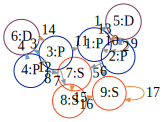

In [12]:
elᶜ = elements(cmpy)
draw(elᶜ)

The visualization of the category of elements isn't the most compact representation of data, but it is always an option. Once you know how to draw a graph homomorphism as a color-coded graph, you know how to draw any C-Set. The vertices and edges of the domain graph are the rows and fields of the C-Set, and the colors are from the vertices and edges of the schema C, viewed as a graph presenting the category. One thing you lose is the ability to represent path equations in C.

## Reconstructing the C-Set from its category of elemnts
When looking at the graphical representation of the category of elements, you can see that the vertices are numbered sequentially within their vertex type. This order can be computed with the incident function in Catlab. There are inclusions of all the tables in the database instance into the global vertex set of the knowledge graph representation.

In [13]:
incident(elᶜ, :, :πₑ)

3-element Vector{AbstractVector{Int64}}:
 [1, 2, 3, 4]
 [5, 6]
 [7, 8, 9]

The same goes for the edges (arrows) in the category of elements.

In [14]:
incident(elᶜ, :, :πₐ)

5-element Vector{AbstractVector{Int64}}:
 [1, 2, 3, 4]
 [5, 6, 7, 8]
 [9, 10, 11, 12]
 [13, 14]
 [15, 16, 17]

From this information, you can reassemble the knowledge graph into a database. You use the codomain graph as the schema and then these two projections πₑ and πₐ to recover the instance data.

In [15]:
cset(T::Type, el::Elements) = begin
  X = T()
  ℓ = Dict{Int, Int}() # this map reverses the inclusions converting global element numbers into per-table numbers
  for ob in parts(el, :Ob)
    obname = el[ob, :nameo]
    eltsob = incident(el, ob, :πₑ)
    pts = add_parts!(X, obname, length(eltsob))
    map(zip(pts, eltsob)) do (i,x)
      ℓ[x] = i
    end
  end
  for h in parts(el, :Hom)
    nameh = el[h, :nameh]
    arrₕ = incident(el, h, :πₐ)
    doms = map(arrₕ) do e
      ℓ[el[e, :src]]
    end
    codoms = map(arrₕ) do e
      ℓ[el[e, :tgt]]
    end
    set_subpart!(X, doms, nameh, codoms)
  end
  return X
end

cset (generic function with 1 method)

We can apply this algorithm to our company knowledge graph to recover our original DB.

In [16]:
cset(Company, elᶜ)
cmpy == cset(Company, elᶜ)

true

Hopefully you see one reason why graphs are ubiquitous in computer science. Every relational database is isomorphic to a typed graph. You can generate this graph from the database and recover the database from the typed graph. So while knowledge graphs are great for ingesting data when you aren't sure about the structure and useful for some types of computation that involve long paths. You can always build your software on relational databases knowing that you can easily get access to all the graph algorithms by applying the Grothendieck construction.

## The Slice-Elements Transform
An amazing fact about presheaf toposes is that they are closed under taking slices. In the graphs section of this documentation, you can find a description of bipartite and k-partite graphs as a morphisms into a clique. That definition is very mathematically pleasing because it gives you a category of partitioned graphs that are derived from commuting triangles in Graph. However, for application oriented practitioners, the definition of a bipartite graph as "a graph with two sets of vertices, where all the edges go between the groups with no edges within either group" is probably more explicit. For example a classic way to get a bipartite graph would be to look at the graph of authors and papers that those authors wrote. People write papers, people do not write people and papers do not write papers so the authorship graph is bipartite. These two equivalent definitions of a bipartite graph are related via an isomorphism you can find on the [nlab](https://ncatlab.org/nlab/show/category+of+presheaves#RelWithOvercategories). It shows that a slice category of [C,Set]/X is isomorphic to [El(X), Set] which is a cateogory of presheaves on a different schema. Catlab knows how to use this idea to turn a category of elements into a schema for a new category of presheaves. The two directions of the isomorphism are not yet implemented.

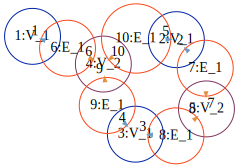

In [17]:
e = @acset Graph begin
  V = 2
  E = 1
  src = 1
  tgt = 2
end

draw(elements(e))

SchBipartite = CatElements.presentation(elements(e))[1]
to_graphviz(SchBipartite)

@acset_type BipartiteGraph(SchBipartite)
b = @acset BipartiteGraph begin
  V_1 = 3
  V_2 = 2
  E_1 = 5
  src_E_1 = [1,2,3,3,2]
  tgt_E_1 = [1,2,2,1,1]
end
draw(elements(b))

As a very advanced exercise, you could try to implement one or both directions of the isomorphism above.